In [18]:
import pandas as pd
import random
import numpy as np
import scipy
import scipy.optimize as sco
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

Here, I am just importing an cleaning the data of returns from the DJSI.

In [19]:
DJSIreturns = pd.read_csv("DJSI returns.csv").dropna(axis = 0)
DJSIquants = np.array(np.array(DJSIreturns)[:,1:], dtype = "float")

In this cell I generate a list of random weights using the randn function, and then plot 50,000 sample portfolios in the risk v. return space.  The black x denotes the portfolio with the optimal Sharpe ratio.  The issue is that the portfolio with the optimal Sharpe ratio has negative weights for some of its assets which does not make sense.  This method was inspired by code from this plotly https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/ which also uses the randn function to generate random weights.  

In [28]:
def generate_random_weights(number): #Generate a list of random weights
    randlist = np.random.randn(number)
    randlist = randlist/np.sum(randlist)
    return randlist

In [29]:
def generate_random_weights_2(number):
    randlist = np.random.random(number)
    randlist = randlist/np.sum(randlist)
    return randlist

In [30]:
def plotty(random_weights):
    mean_returns = np.mean(DJSIquants, axis = 1)
    covariance_returns = np.cov(DJSIquants) 

    #Calculate the expected returns and variance with the random weights
    expected_returns = [np.dot(mean_returns, random_weights[i]) for i in range(50000)]  
    rand_risks = [np.sqrt(np.matmul(np.matmul(random_weights[i], covariance_returns),random_weights[i].T)) for i in range(50000)] 
    sharpe_ratio = [expected_returns[i]/rand_risks[i] for i in range(50000)]

    index = sharpe_ratio.index(max(sharpe_ratio))
    optimal_weights = random_weights[index]

    plt.figure(figsize = (20, 15))
    plt.scatter(rand_risks, expected_returns, c = sharpe_ratio, cmap = 'inferno', marker= 'o')
    plt.plot(rand_risks[index], expected_returns[index], "kx")
    plt.xlim(0, .1)
    plt.ylim(-0.025, 0.025)
    plt.show()

    print(optimal_weights)



In this example, I use the random function that does not normally distribute its output.  The same workflow ensues to make the graph, but instead of getting the classical bullet, I get a circle.  However, all of the weights for the assets in each portfolio are positive.  

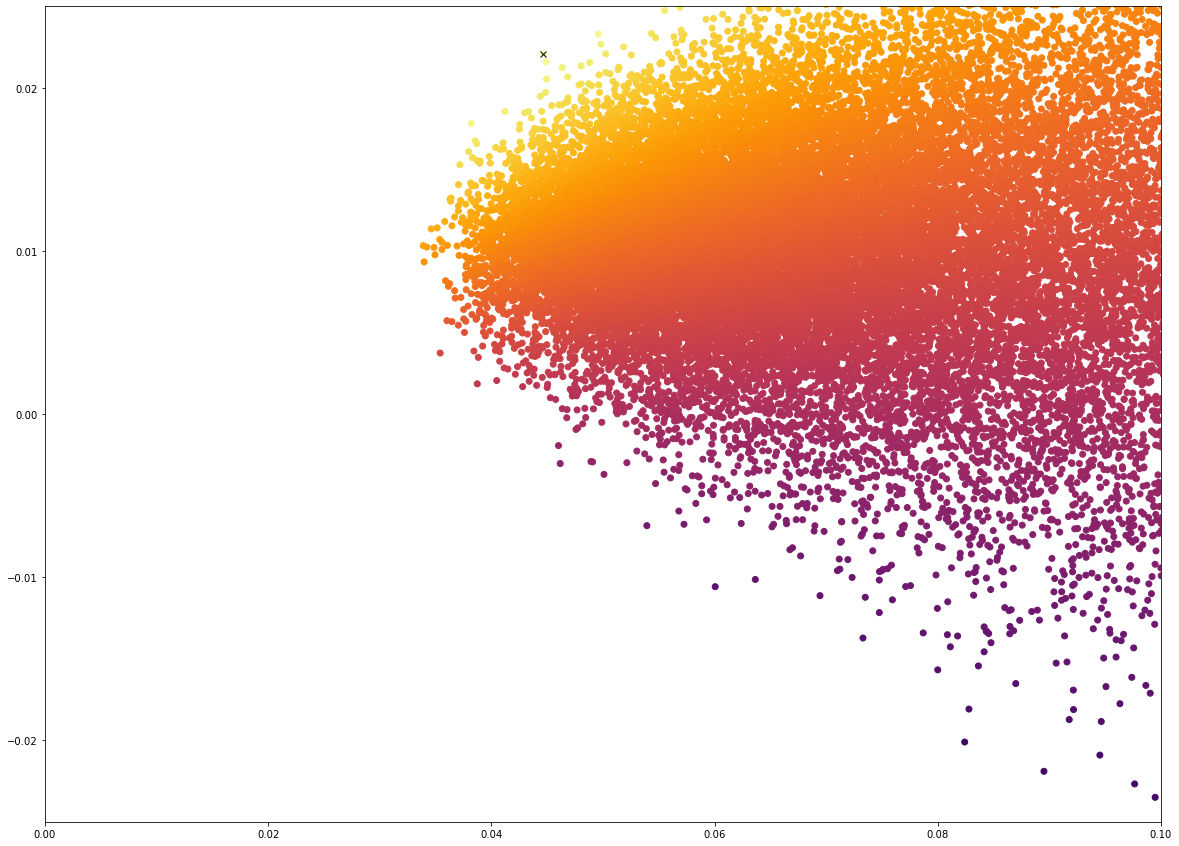

[ 0.18361649 -0.16672196  0.19173173 -0.09514183 -0.07397843  0.13224092
  0.02124154  0.14605033 -0.02187891  0.3211268  -0.06804919 -0.12425313
  0.01656571  0.32473622  0.23339583 -0.0558884  -0.13875431 -0.08046171
  0.02511752 -0.19382705  0.25939681 -0.10925866 -0.07674693 -0.14198121
  0.49172181]


In [31]:
plotty(np.array([generate_random_weights(np.shape(DJSIquants)[0]) for i in range(50000)]))

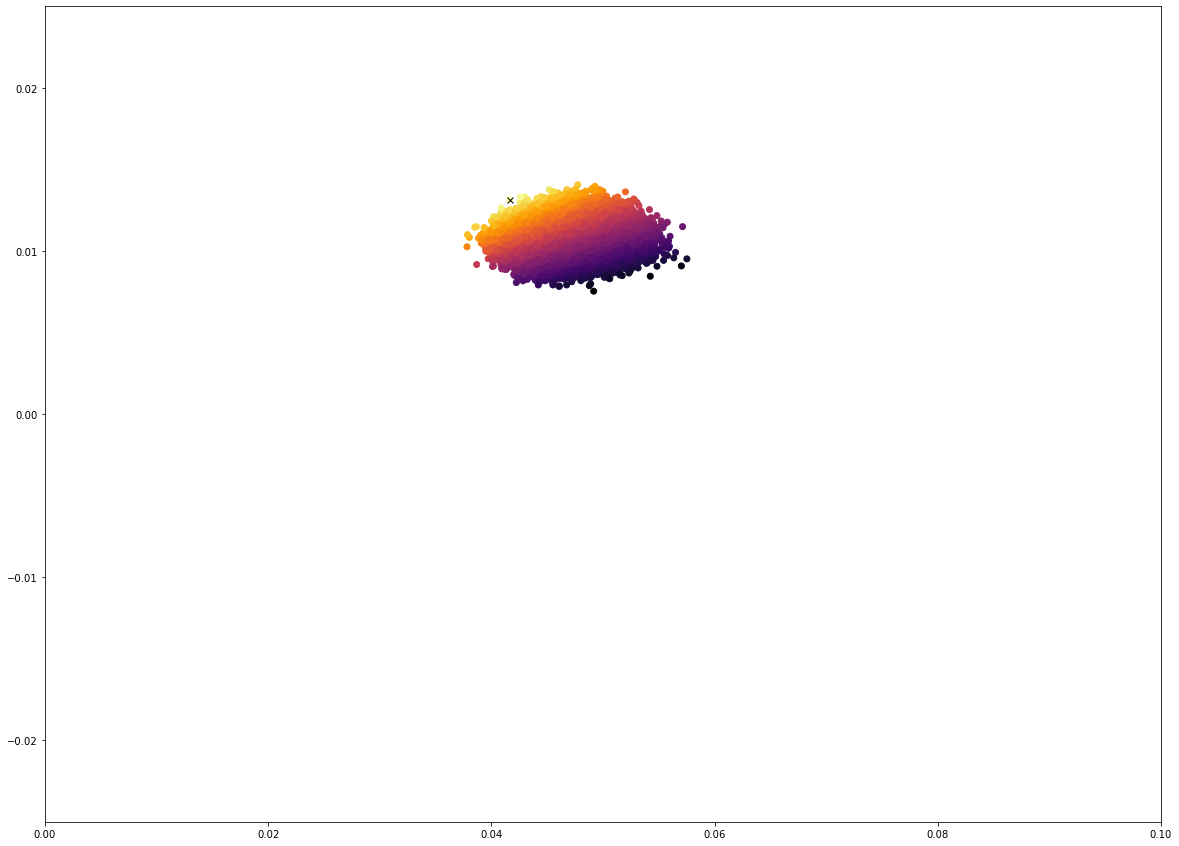

[0.01893083 0.03755223 0.04002472 0.00877778 0.00441491 0.06170866
 0.0763001  0.05604417 0.00027331 0.07126379 0.04546767 0.00622123
 0.01115986 0.07610499 0.07761372 0.04102323 0.0604422  0.0402337
 0.0033905  0.06658035 0.0642087  0.00727051 0.04737686 0.00826559
 0.06935038]


In [32]:
plotty(np.array([generate_random_weights_2(np.shape(DJSIquants)[0]) for i in range(50000)]))

Here I am putting our data through sample code given straight from https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

with no modifications.  This script uses the random function, not normally distributed.  The output we get here is also a bubble of portfolios in the risk v. return space, which is consistent with the results in this script.  However, in the github link, the authors get a classical bullet shaped mass of portfolios.

No handles with labels found to put in legend.


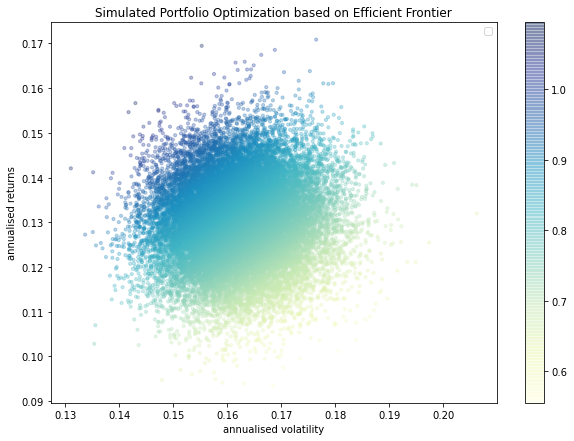

In [24]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * 12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

display_simulated_ef_with_random(mean_returns, covariance_returns, 25000, 0)